# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

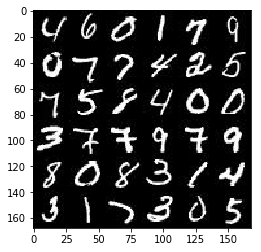

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

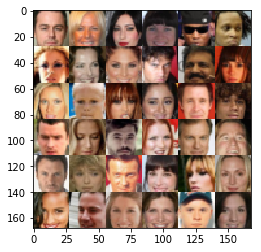

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learningrate = tf.placeholder(tf.float32)
    return input_real, input_z, learningrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/changkun/anaconda3/envs/dlnd-tf-lab/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/changkun/anaconda3/envs/dlnd-tf-lab/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/changkun/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/changkun/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/changkun/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoo

### Leaky ReLU
There is no LeakyReLU API in tensorflow, so it must be implemented.

In [6]:
def Leaky_ReLU(x, alpha):
    return tf.maximum(x, alpha*x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator",reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=(not is_train)):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3or5 
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_trainable = tf.trainable_variables()
    g_var = [v for v in vars_trainable if 'generator' in v.name]
    d_var = [v for v in vars_trainable if 'discriminator' in v.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
        d_optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        
    return d_optmizer, g_optmizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _ , image_width, image_height, image_channels = data_shape
    input_real, input_z, learningrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_optmizer, g_optmizer = model_opt(d_loss, g_loss, learning_rate, beta1)

    # Plot data
    samples, losses = [], []
    steps = 0
    print_every = 25
    show_every = 250
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                #tf.random_uniform(shape=(batch_size, z_dim),minval=-1,maxval=1)
                sess.run(d_optmizer, feed_dict=
                         {input_real:batch_images, input_z:batch_z, learningrate:learning_rate})
                sess.run(g_optmizer, feed_dict=
                         {input_real:batch_images, input_z:batch_z, learningrate:learning_rate})
                
                if steps % show_every == 0:
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
    import matplotlib.pyplot as plt            
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3127... Generator Loss: 10.4690
Epoch 1/2... Discriminator Loss: 0.0397... Generator Loss: 4.3922
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 1.7218
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 0.1026... Generator Loss: 3.9575
Epoch 1/2... Discriminator Loss: 0.0258... Generator Loss: 4.2467
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 14.2044
Epoch 1/2... Discriminator Loss: 0.5733... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.8436... Generator Loss: 7.1419


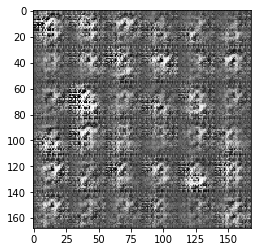

Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 4.9713
Epoch 1/2... Discriminator Loss: 0.2572... Generator Loss: 2.3362
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 1.9308
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 1.6359
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.3338
Epoch 1/2... Discriminator Loss: 0.1772... Generator Loss: 3.6742
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 1.1670
Epoch 1/2... Discriminator Loss: 0.2821... Generator Loss: 2.0260
Epoch 1/2... Discriminator Loss: 0.1592... Generator Loss: 2.4725


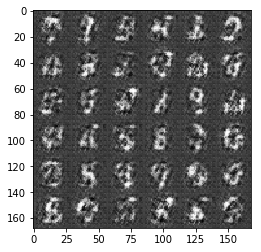

Epoch 1/2... Discriminator Loss: 0.0403... Generator Loss: 5.1515
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.9232
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.4698
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.9406... Generator Loss: 4.3423
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 0.0567... Generator Loss: 4.3729
Epoch 1/2... Discriminator Loss: 0.2508... Generator Loss: 1.7915
Epoch 1/2... Discriminator Loss: 0.1451... Generator Loss: 2.3445


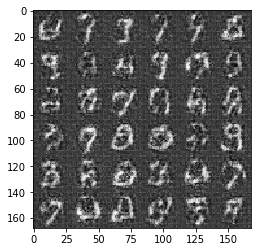

Epoch 1/2... Discriminator Loss: 0.0334... Generator Loss: 3.8580
Epoch 1/2... Discriminator Loss: 0.0189... Generator Loss: 5.3005
Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 1.9718
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 3.1515
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 2.1810
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 1.9729
Epoch 1/2... Discriminator Loss: 0.5236... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 0.6581... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 1.3369


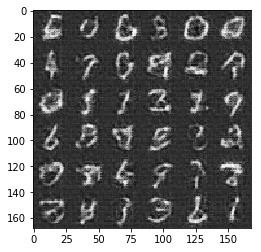

Epoch 2/2... Discriminator Loss: 0.2739... Generator Loss: 2.1640
Epoch 2/2... Discriminator Loss: 1.0396... Generator Loss: 3.2631
Epoch 2/2... Discriminator Loss: 0.0713... Generator Loss: 3.8020
Epoch 2/2... Discriminator Loss: 0.1176... Generator Loss: 2.9133
Epoch 2/2... Discriminator Loss: 0.0641... Generator Loss: 4.3890
Epoch 2/2... Discriminator Loss: 0.1052... Generator Loss: 2.6252
Epoch 2/2... Discriminator Loss: 0.0549... Generator Loss: 3.3113
Epoch 2/2... Discriminator Loss: 0.0372... Generator Loss: 3.7679
Epoch 2/2... Discriminator Loss: 0.0405... Generator Loss: 3.6612
Epoch 2/2... Discriminator Loss: 0.0169... Generator Loss: 5.9780


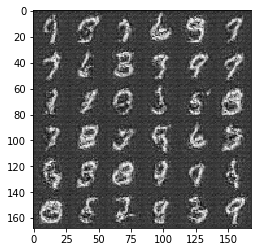

Epoch 2/2... Discriminator Loss: 0.1154... Generator Loss: 5.9542
Epoch 2/2... Discriminator Loss: 10.6653... Generator Loss: 14.9703
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 2.3644
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.2309... Generator Loss: 2.8093
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 1.8645
Epoch 2/2... Discriminator Loss: 0.1062... Generator Loss: 2.6218
Epoch 2/2... Discriminator Loss: 0.2225... Generator Loss: 1.9561
Epoch 2/2... Discriminator Loss: 0.0375... Generator Loss: 3.8848


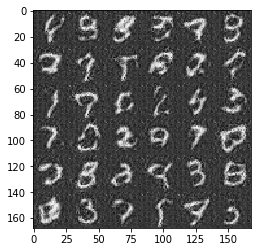

Epoch 2/2... Discriminator Loss: 0.3053... Generator Loss: 1.5461
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 1.5845
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.1175
Epoch 2/2... Discriminator Loss: 0.6883... Generator Loss: 2.0378
Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 1.8275
Epoch 2/2... Discriminator Loss: 0.0317... Generator Loss: 4.6189
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 2.4314
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 1.3323


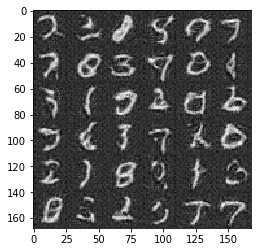

Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 2.6225
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 0.1977... Generator Loss: 2.0777
Epoch 2/2... Discriminator Loss: 0.1042... Generator Loss: 2.6145
Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 6.2845


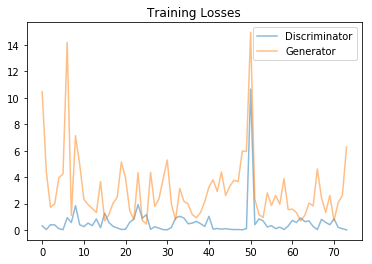

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2481... Generator Loss: 0.0411
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 5.3378
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 3.7062
Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 3.1123
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 2.4203
Epoch 1/1... Discriminator Loss: 3.0962... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.0519


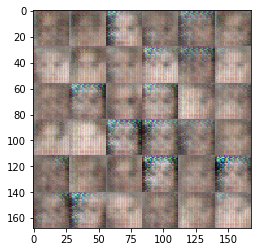

Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 1.6751
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 3.2488
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.5694


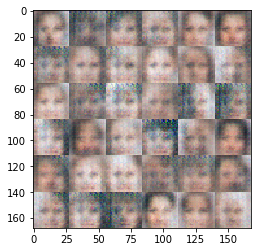

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 3.7763... Generator Loss: 2.9852
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.1260... Generator Loss: 3.0045
Epoch 1/1... Discriminator Loss: 2.0285... Generator Loss: 0.1982
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 2.4840... Generator Loss: 0.1121
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 5.0462


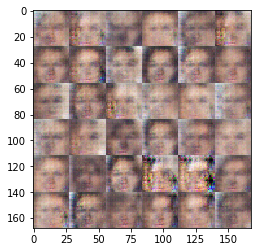

Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 3.8379
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 3.0804
Epoch 1/1... Discriminator Loss: 1.8829... Generator Loss: 0.2356
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 2.4423
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 3.5901
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 1.7000
Epoch 1/1... Discriminator Loss: 0.2015... Generator Loss: 2.5812
Epoch 1/1... Discriminator Loss: 1.8519... Generator Loss: 0.2074


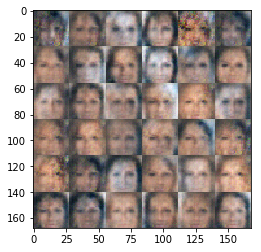

Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 3.1384
Epoch 1/1... Discriminator Loss: 0.3150... Generator Loss: 2.4620
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.9672
Epoch 1/1... Discriminator Loss: 2.6056... Generator Loss: 0.0922
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 3.7705


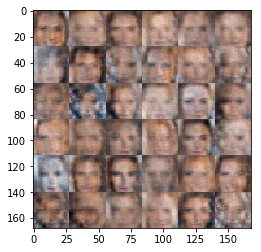

Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 3.8341
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.6642
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.9059
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 3.2436
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 0.2877... Generator Loss: 4.3417
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 0.9855


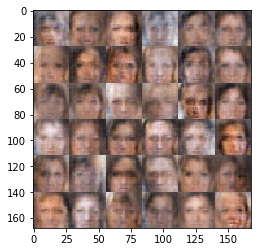

Epoch 1/1... Discriminator Loss: 1.7944... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.3079... Generator Loss: 3.1118
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 3.8070
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 3.5961
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.5626


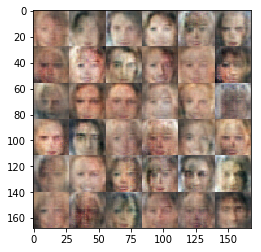

Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 2.2302
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 3.6016
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 3.2543
Epoch 1/1... Discriminator Loss: 1.6573... Generator Loss: 0.3507
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.6260


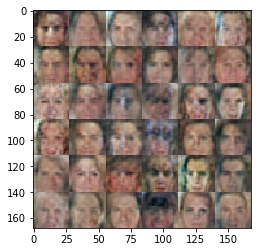

Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 2.4971... Generator Loss: 4.1814
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.3876


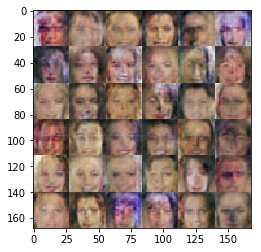

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 1.8634
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 1.6126
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.7282


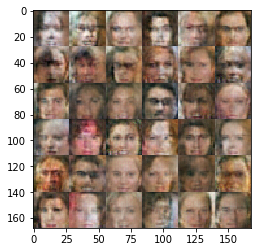

Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.3897
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.4288
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.4398
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.7415


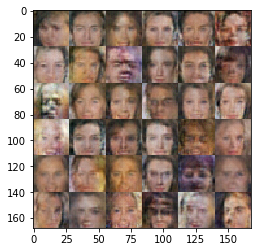

Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 2.3848
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 2.1590


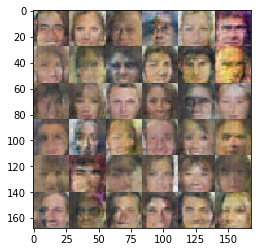

Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.3014
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.7597
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.6886
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.3823


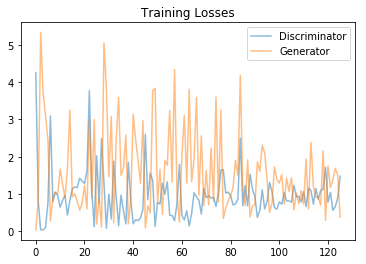

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.